In [ ]:
# install verdict
!uv pip install verdict --system

# This notebook has been run ahead of time, so you can inspect outputs without making
# any API calls. You can set your API key if you want to run the examples yourself.
# %env OPENAI_API_KEY=*************************

## `ConversationalUnit` Usage

A `ConversationalUnit` simply keeps track of the current conversation (using the `verdict.common.conversational.Conversation` helper class). **Note that we default the InputSchema to an empty `Conversation` if none is passed (e.g., the very first `ConversationalUnit` in the `Layer` below has no `conversation` field in the input).**

In [6]:
from verdict import Pipeline, Layer
from verdict.common.conversational import ConversationalUnit
from verdict.schema import Schema

pipeline = Pipeline() \
>> Layer(
    ConversationalUnit("Thinker").prompt("""
        Is this joke funny? Read arguments from those before you and come up with a brief, but unique, stance.

        Joke:
        {source.joke}

        Others' thoughts:
        {input.conversation}
    """)
, 4, inner='chain')

response, _ = pipeline.run(Schema.of(joke="Why did the chicken cross the road? Because the other side had better documentation."))
response['Pipeline_root.block.layer[3].unit[Thinker #4]_conversation']

<Thinker #1>
The joke plays on the classic "chicken crossing the road" setup, which is a well-known format in humor. The punchline introduces a twist by referencing "better documentation," which adds an element of tech humor that may resonate with those familiar with the frustrations of poor documentation in software or technical fields. 

While it may not appeal to everyone, particularly those outside of tech circles, it cleverly combines a classic joke structure with a modern, relatable theme. Ultimately, its humor is subjective; tech enthusiasts might find it amusing, while others might view it as a niche or less engaging punchline.
</Thinker #1>

<Thinker #2>
The joke cleverly merges a classic format with contemporary tech humor, making it relatable for those familiar with the frustrations of poor documentation. While it might not resonate with everyone, especially non-tech audiences, its unique twist on a familiar setup adds a layer of cleverness that could elicit a chuckle from t

We can also change the role_names of a conversation at runtime using `with_roles`. This can be helpful when re-labeling the proponent as the opponent of the inverse task, for example.

In [7]:
response['Pipeline_root.block.layer[3].unit[Thinker #4]_conversation'].with_roles(['Paul', 'Ringo', 'John', 'George'])

<Paul>
The joke plays on the classic "chicken crossing the road" setup, which is a well-known format in humor. The punchline introduces a twist by referencing "better documentation," which adds an element of tech humor that may resonate with those familiar with the frustrations of poor documentation in software or technical fields. 

While it may not appeal to everyone, particularly those outside of tech circles, it cleverly combines a classic joke structure with a modern, relatable theme. Ultimately, its humor is subjective; tech enthusiasts might find it amusing, while others might view it as a niche or less engaging punchline.
</Paul>

<Ringo>
The joke cleverly merges a classic format with contemporary tech humor, making it relatable for those familiar with the frustrations of poor documentation. While it might not resonate with everyone, especially non-tech audiences, its unique twist on a familiar setup adds a layer of cleverness that could elicit a chuckle from those in the know.

### with_leaf/with_root

As discussed in the [Layer documentation](verdict.haizelabs.com/docs/concept/layer), we can use the `with_leaf` directive to specify which leafs in our `Layer` should link to the dependents. We can use this to only condition on, for example, the `Opponent` `ConversationalUnit`s.

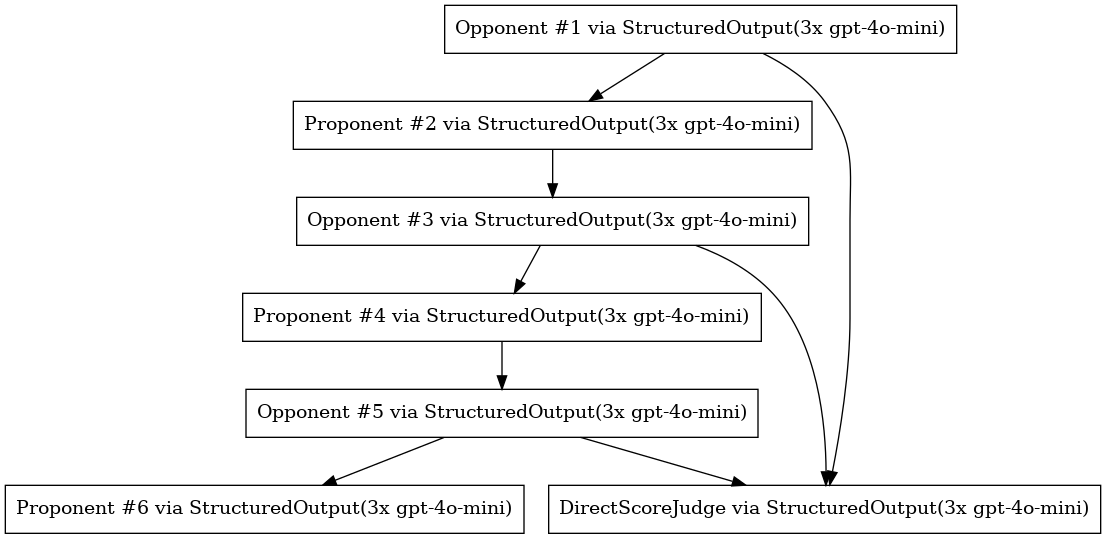

In [13]:
from verdict.common.conversational import ConversationalUnit
from verdict.common.judge import JudgeUnit
from verdict.scale import BooleanScale

pipeline = Pipeline() \
    >> Layer([
        ConversationalUnit(role_name='Proponent').prompt("""
            You are in a debate. Your are the Proponent, arguing that the following joke is funny. Continue the conversation.
    
            Joke:
            {source.joke}
    
            Debate thus far:
            {input.conversation}
        """),
        ConversationalUnit(role_name='Opponent').prompt("""
            You are in a debate. Your are the Opponent, arguing that the following joke is not funny. Continue the conversation.
    
            Joke:
            {source.joke}
    
            Debate thus far:
            {input.conversation}
        """)
    ], 3, inner='chain', outer='broadcast').with_leaf([0, 2, 4]) \
    >> JudgeUnit(BooleanScale()).prompt("""
        Use the following arguments to determine if the following joke is funny.

        Joke:
        {source.joke}

        Debater #1:
        {previous.conversational[0].response}

        Debater #2:
        {previous.conversational[1].response}

        Debater #3:
        {previous.conversational[2].response}
    """)

pipeline.plot()

In [14]:
response, _ = pipeline.run(Schema.of(joke="Why did the chicken cross the road? Because the other side had better documentation."))
response['Pipeline_root.block.block.unit[DirectScoreJudge]_score']

False

### Numbering

When using `ConversationalUnit` in a `Layer`, pass `number=False` to avoid automatically appending an `#{idx}`. This is particular important if you plan to change the role names using `.with_roles()`.